# Stock Market Prediction Using Stacked LSTM

#### Anurag Kujur - M210691CA
#### Saurav Kumar - M210682CA

In [121]:
# The goal of time series forecasting is to predict future values of a variable based on its historical behavior. 
# We are using an LSTM (Long Short-Term Memory) neural network to predict the future stock prices of Tata Motors.
# LSTMs are a type of recurrent neural network (RNN) that are specifically designed for time series prediction.

In [122]:
# Data Collection
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

In [123]:
df=pd.read_csv('TataMotors.csv')

In [124]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,156.303482,164.040497,156.184769,163.535919,153.140778,27906448
1,2010-01-05,162.259598,167.147186,153.246277,160.686478,150.472473,23669317
2,2010-01-06,162.200241,162.932388,159.311234,160.933823,150.704086,14990820
3,2010-01-07,161.171280,161.923218,154.344498,155.432831,145.552765,22722030
4,2010-01-08,156.323273,159.251862,155.343781,156.283707,146.349579,16495776


In [125]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3273,2023-04-06,426.500000,439.299988,423.750000,437.649994,437.649994,10907492
3274,2023-04-10,452.049988,473.299988,452.000000,461.299988,461.299988,50462653
3275,2023-04-11,463.750000,463.750000,455.799988,458.700012,458.700012,14495222
3276,2023-04-12,459.350006,468.600006,458.200012,465.500000,465.500000,13552440
3277,2023-04-13,464.950012,472.000000,463.250000,469.500000,469.500000,12733670


In [126]:
df1=df.reset_index()['Close']    #Select the 'Close' column

In [127]:
df1

0       163.535919
1       160.686478
2       160.933823
3       155.432831
4       156.283707
           ...    
3273    437.649994
3274    461.299988
3275    458.700012
3276    465.500000
3277    469.500000
Name: Close, Length: 3278, dtype: float64

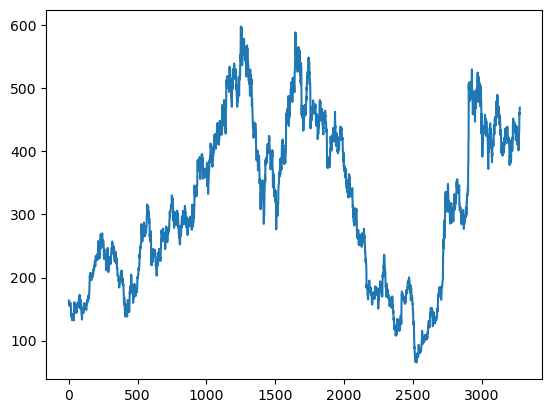

In [128]:
plt.plot(df1)

In [129]:
# LSTM are sensitive to the scale of the data.So we apply MinMax scaler and scale our values between 0 to 1

In [130]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))     #scale down in the range 0,1
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [131]:
print(df1)

[[0.18436482]
 [0.17901711]
 [0.17948132]
 ...
 [0.73831572]
 [0.75107763]
 [0.75858466]]


In [132]:
# splitting dataset into train and test split
training_size=int(len(df1)*0.65)   #65% training size
test_size=len(df1)-training_size    #35% test size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [133]:
training_size,test_size

(2130, 1148)

In [134]:
train_data

array([[0.18436482],
       [0.17901711],
       [0.17948132],
       ...,
       [0.34419699],
       [0.34438467],
       [0.34907656]])

In [135]:
# DATA PREPROCESSING to be fed into LSTM model
# create_dataset to convert the time series data into a format that can be fed into the LSTM network
# This function creates a sliding window of time steps and associates each window with a corresponding output value. 
# The sliding window of time steps is created using a user-defined variable called 'time_step'.
# Input data is a sequence of 100 stock prices, and the output data is the stock price that follows that sequence.
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)                                 #append in X_train
		dataY.append(dataset[i + time_step, 0])         #append in Y_train
	return numpy.array(dataX), numpy.array(dataY)

In [136]:
# The training and test data are then converted into the required format using the create_dataset function. 
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [137]:
#X_train== 100 days data value (100 columns=100 features=independent variables)
#Y_train== Value after 100 days (dependent variable)
print(X_train.shape), print(y_train.shape)       

(2029, 100)
(2029,)


(None, None)

In [138]:
print(X_test.shape), print(ytest.shape)

(1047, 100)
(1047,)


(None, None)

In [139]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# Input to the LSTM network should be a 3D array, so the X_train and X_test arrays are reshaped accordingly.
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)    
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)    

In [140]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [141]:
# The program creates an LSTM model using the Sequential class from the keras.models module.
# The model consists of three LSTM layers with 50 units each, followed by a dense output layer with one unit.
# The model is then compiled using the mean squared error as the loss function and the Adam optimizer.

model=Sequential()   #creates an instance of a Sequential model.

model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))  
# adds an LSTM layer to the model with 50 units.  
# The input_shape=(100,1) argument specifies the shape of the input data that the model will expect

model.add(LSTM(50,return_sequences=True))
# adds another LSTM layer with 50 units and return_sequences=True.

model.add(LSTM(50))
# adds a final LSTM layer with 50 units. Since return_sequences is not specified,
# it defaults to False, meaning that this layer will only return the last output in the sequence.

model.add(Dense(1))
# adds a Dense layer with 1 unit. This is the output layer of the model.

model.compile(loss='mean_squared_error',optimizer='adam')
# compiles the model and specifies the loss function and optimizer to use during training


In [142]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [143]:
# We train the model using the fit function of the model object. 
#The training process takes 50 epochs, and the batch size is set to 64.

#model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)
#model.save_weights('model.h5')

In [144]:
#To load the already trained model

model.load_weights('model.h5')

In [145]:
# After training the model, we use it to make predictions on the training and testing datasets. 
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

33/33 [==============================] - 1s 30ms/step


In [146]:
# The predictions are scaled back to their original range using the inverse_transform method of the scaler object.
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [147]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

#Train data RMSE
math.sqrt(mean_squared_error(y_train,train_predict))

365.383475871724

In [148]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

311.31759563659375

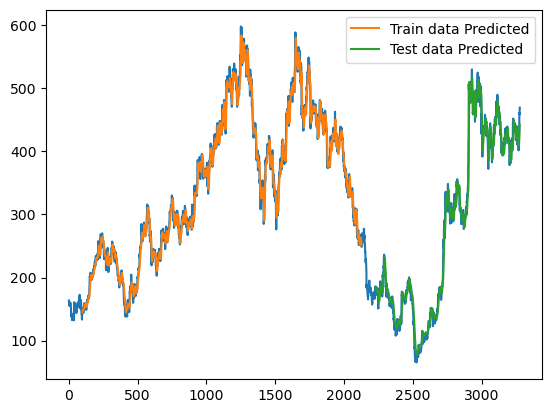

In [149]:
# Plot the actual and predicted stock prices for both the training and test data
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot,label='Train data Predicted')
plt.plot(testPredictPlot,label='Test data Predicted')
plt.legend()
plt.show()


In [150]:
len(test_data)

1148

In [151]:
#Taking the last 100 days test_data in x_input 
x_input=test_data[1048:].reshape(1,-1)  
x_input.shape

(1, 100)

In [152]:
# Converting x_input into a list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [153]:
# We generate predictions for the next 30 days using the last 100 days of data from the test dataset. 
# The predictions are stored in a list called lst_output
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.74432313]
101
1 day input [0.66774969 0.67450602 0.67328609 0.67206621 0.69045845 0.69055226
 0.69036457 0.7020943  0.69993604 0.69458727 0.68210686 0.67901022
 0.66587293 0.66043035 0.65311096 0.65470621 0.66287011 0.66174405
 0.65949198 0.66868807 0.66193174 0.64785607 0.63302971 0.61773416
 0.58751838 0.59962342 0.6171711  0.61182234 0.60168787 0.60553525
 0.61839098 0.61670191 0.60112486 0.60356462 0.59436853 0.60835038
 0.65236027 0.66230711 0.65114039 0.64973282 0.65254796 0.65686447
 0.64391487 0.6295577  0.6340619  0.64391487 0.66972026 0.66390231
 0.71373021 0.71007051 0.72592912 0.71570078 0.71222877 0.7134487
 0.70697387 0.69468115 0.70340805 0.69712091 0.71419939 0.70519093
 0.70425255 0.71100889 0.70622318 0.70303267 0.70885063 0.69665172
 0.68342061 0.69045845 0.6802301  0.66183792 0.666999   0.67694578
 0.66652981 0.68069929 0.70340805 0.70190661 0.68858169 0.69543184
 0.67018945 0.6593981  0.64945132 0.65761522 0.66380849 0.64832526
 0.65170339 0.65836591 0.66408999 

8 day output [[0.7380765]]
9 day input [0.69993604 0.69458727 0.68210686 0.67901022 0.66587293 0.66043035
 0.65311096 0.65470621 0.66287011 0.66174405 0.65949198 0.66868807
 0.66193174 0.64785607 0.63302971 0.61773416 0.58751838 0.59962342
 0.6171711  0.61182234 0.60168787 0.60553525 0.61839098 0.61670191
 0.60112486 0.60356462 0.59436853 0.60835038 0.65236027 0.66230711
 0.65114039 0.64973282 0.65254796 0.65686447 0.64391487 0.6295577
 0.6340619  0.64391487 0.66972026 0.66390231 0.71373021 0.71007051
 0.72592912 0.71570078 0.71222877 0.7134487  0.70697387 0.69468115
 0.70340805 0.69712091 0.71419939 0.70519093 0.70425255 0.71100889
 0.70622318 0.70303267 0.70885063 0.69665172 0.68342061 0.69045845
 0.6802301  0.66183792 0.666999   0.67694578 0.66652981 0.68069929
 0.70340805 0.70190661 0.68858169 0.69543184 0.67018945 0.6593981
 0.64945132 0.65761522 0.66380849 0.64832526 0.65170339 0.65836591
 0.66408999 0.6591166  0.65076502 0.63115295 0.64541631 0.66718663
 0.67366146 0.67797797 0.

16 day output [[0.7204644]]
17 day input [0.66287011 0.66174405 0.65949198 0.66868807 0.66193174 0.64785607
 0.63302971 0.61773416 0.58751838 0.59962342 0.6171711  0.61182234
 0.60168787 0.60553525 0.61839098 0.61670191 0.60112486 0.60356462
 0.59436853 0.60835038 0.65236027 0.66230711 0.65114039 0.64973282
 0.65254796 0.65686447 0.64391487 0.6295577  0.6340619  0.64391487
 0.66972026 0.66390231 0.71373021 0.71007051 0.72592912 0.71570078
 0.71222877 0.7134487  0.70697387 0.69468115 0.70340805 0.69712091
 0.71419939 0.70519093 0.70425255 0.71100889 0.70622318 0.70303267
 0.70885063 0.69665172 0.68342061 0.69045845 0.6802301  0.66183792
 0.666999   0.67694578 0.66652981 0.68069929 0.70340805 0.70190661
 0.68858169 0.69543184 0.67018945 0.6593981  0.64945132 0.65761522
 0.66380849 0.64832526 0.65170339 0.65836591 0.66408999 0.6591166
 0.65076502 0.63115295 0.64541631 0.66718663 0.67366146 0.67797797
 0.69880997 0.74319524 0.73831572 0.75107763 0.75858466 0.74432313
 0.75300115 0.75608146

24 day output [[0.7159363]]
25 day input [0.58751838 0.59962342 0.6171711  0.61182234 0.60168787 0.60553525
 0.61839098 0.61670191 0.60112486 0.60356462 0.59436853 0.60835038
 0.65236027 0.66230711 0.65114039 0.64973282 0.65254796 0.65686447
 0.64391487 0.6295577  0.6340619  0.64391487 0.66972026 0.66390231
 0.71373021 0.71007051 0.72592912 0.71570078 0.71222877 0.7134487
 0.70697387 0.69468115 0.70340805 0.69712091 0.71419939 0.70519093
 0.70425255 0.71100889 0.70622318 0.70303267 0.70885063 0.69665172
 0.68342061 0.69045845 0.6802301  0.66183792 0.666999   0.67694578
 0.66652981 0.68069929 0.70340805 0.70190661 0.68858169 0.69543184
 0.67018945 0.6593981  0.64945132 0.65761522 0.66380849 0.64832526
 0.65170339 0.65836591 0.66408999 0.6591166  0.65076502 0.63115295
 0.64541631 0.66718663 0.67366146 0.67797797 0.69880997 0.74319524
 0.73831572 0.75107763 0.75858466 0.74432313 0.75300115 0.75608146
 0.75570333 0.75336516 0.74998081 0.7460928  0.74204493 0.73807651
 0.73436308 0.73102868

In [154]:
day_new=np.arange(1,101)     #100 days input
day_pred=np.arange(101,131)  #Next 30 days output

In [155]:
import matplotlib.pyplot as plt

In [156]:
len(df1)

3278

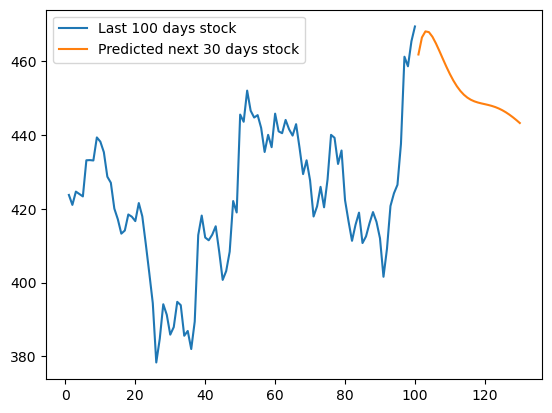

In [157]:
plt.plot(day_new,scaler.inverse_transform(df1[3178:]),label='Last 100 days stock')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Predicted next 30 days stock')
plt.legend()

In [158]:
df3=df1.tolist()
df3.extend(lst_output)

In [159]:
# The output of the model is then transformed back to the original scale,
# Plot predicted values for the next 30 days against the actual values for the last 100 days of the test dataset
df3=scaler.inverse_transform(df3).tolist()

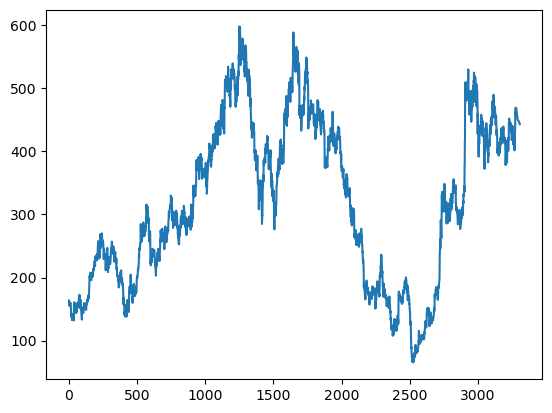

In [160]:
plt.plot(df3)
plt.show()
#Final Graph